In [52]:
import numpy as np
import matplotlib.pyplot as plt

from load_vector_non_smooth import elemental_load_vector_non_smooth_solution
from stiffness_matrix import stiffness_matrix
from load_vector import load_vector
# import sympy as sp

### Utilities

In [33]:
def midpoint_rule(f, dx):
    return (f[2:] - f[:-2]) / (2*dx)

def simpsons_rule(f, dx):
    return dx * (f[0] + 4*np.sum(f[1:-1:2]) + 2*np.sum(f[2:-1:2]) + f[-1]) / 3

def sobolev_norm(f, dx):
    '''
    function to calculate H1-norm.
    - f: array with function values
    - dx: h
    '''
    # Calculate the derivative of f using the midpoint rule
    df = np.zeros_like(f)
    df[1:-1] = midpoint_rule(f, dx)
    # Calculate the L^2 norm of f and df using Simpson's rule
    l2_norm_f = np.sqrt(simpsons_rule(f**2, dx))
    l2_norm_df = np.sqrt(simpsons_rule(df**2, dx))
    # Calculate the H^1 norm of f
    h1_norm_f = np.sqrt(l2_norm_f**2 + l2_norm_df**2)
    return h1_norm_f


def loglog_error(f, u, norm='inf'):
    '''
    for calculating the error of FEM. returns array of errors e for different h found in the returned array H.
    - f: r.h.s function for the given solution u
    - u: solution to problem
    - norm: which norm should be used to calculate the error
    '''
    iterations = 50
    M = np.logspace(1,2,iterations, dtype=int)
    print(M)
    H = 1/M
    e = np.zeros_like(H)
    for i in range(iterations):
        X = np.linspace(0, 1, M[i])
        h = 1/M[i]
        A = stiffness_matrix(alpha=1, b=1, c=2, H=np.full_like(X, h), M=len(X))
        F = load_vector(f, X, len(X))
        u_num = np.linalg.solve(A, F)
        if norm == 'inf':
            e[i] = np.max(np.abs(u(X[1:-1]) - u_num))
        elif norm == 'L2':
            e[i] = np.sqrt(simpsons_rule((u(X[1:-1]) - u_num)**2, h)) # np.sum((u(X[1:-1]) - u_num)**2))
        elif norm == 'H1':
            e[i] = sobolev_norm(u(X[1:-1]) - u_num, h)
    return e, H


def loglogplot_error(h, e, ax=None):
    ''' 
    plotting function. uses logarithmic ploting scale
    - h: array of h-values
    - e: array with error values
    - ax: potential given plt object'''

    if ax is None:
        _, ax = plt.subplots()

    p = np.polyfit(np.log(h), np.log(e), 1)[0]

    ax.set_title("Error")
    ax.loglog(h, e, label=f"p={p:.3f}")
    ax.set_xlabel("h")
    ax.set_ylabel("e")
    ax.invert_xaxis()
    plt.legend()
    return plt

# Example using a solution with constant rhs

Let $c_1=-\frac{e^2 + e}{e^2 + e + 1}$, $c_1=-\frac{1}{e^2 + e + 1}$, and
$$
u(x)=c_1e^{-x} + c_2 e^{2x} + 1
$$
Then, using $\alpha=1$, $b=1$ and $c=2$, we have
$$
f(x)=-(Lu)(x) = 2
$$
This results in the elemental load vector
$$
\vec{F}^{K_i} = h_i (1, 1)^T
$$

In [17]:
M = 100
X = np.sort(np.random.random(M))
X[[0, -1]] = [0, 1]
H = np.diff(X)

def f(x):
    return 2

A = stiffness_matrix(alpha=1, b=1, c=2, H=H, M=M)
F = load_vector(f, X, M)

In [18]:
U = np.linalg.solve(A, F)

In [19]:
def u(x):
    return (-np.exp(2*x)) / (np.exp(1) + np.exp(2) + 1) + np.exp(-x) * (-np.exp(1)- np.exp(2)) / (np.exp(1) + np.exp(2) + 1) + 1

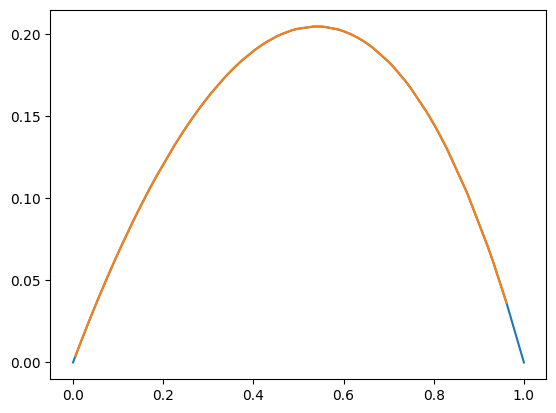

In [20]:
plt.plot(X, u(X))
plt.plot(X[1:-1], U)

## 2b

We have two possible test solutions 
$$u_1(x) = x(1-x)$$
and
$$u_2(x) = sin(3 \pi x)$$
This gives the right hand sides 
$$f_1(x) = cx^2 + (c-2b)x + (b-2\alpha)$$
and 
$$f_2(x) = (9\pi^2\alpha+c)sin(3\pi x) + 3\pi b cos(3\pi x)$$
respectively. 

we implement the r.h.s:

In [21]:
def u2b_1(x):
    return x*(1-x)

def f2b_1(x, alpha=1, b=1, c=2):
    return -c*x**2 + (c-2*b)*x + (b+2*alpha)

def u2b_2(x):
    return np.sin(3*np.pi*x)

def f2b_2(x, alpha=1, b=1, c=2):
    return (9*np.pi**2 * alpha + c)*np.sin(3*np.pi*x) + 3*np.pi*b*np.cos(3*np.pi*x)

We then find the load vector and test the method:

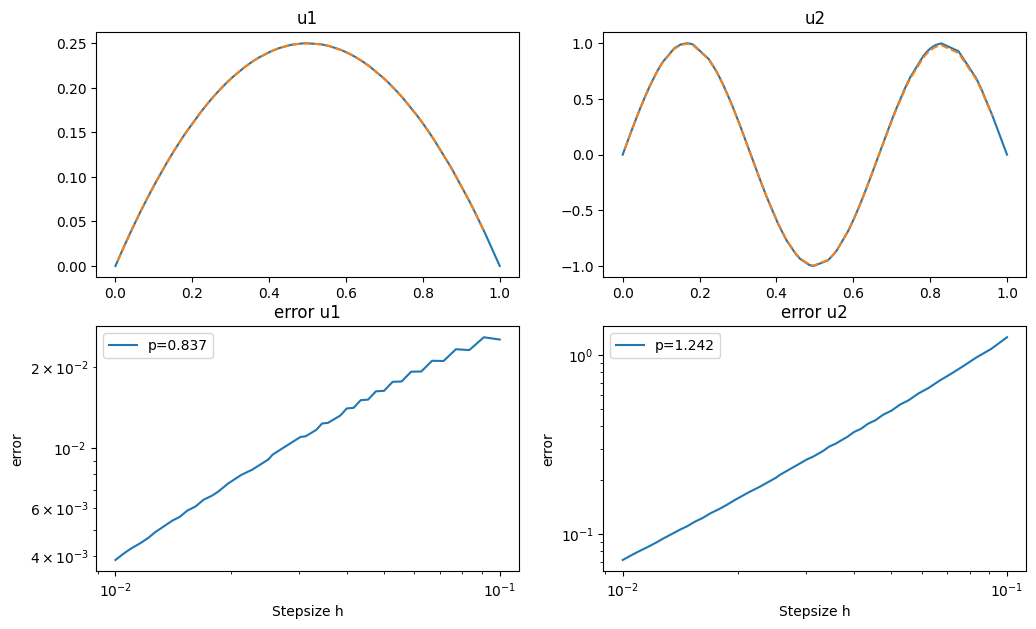

In [22]:
# here we construct the load-vector
F_2b1 = load_vector(f2b_1, X, M)
F_2b2 = load_vector(f2b_2, X, M)

# here we calculate the numerical solution
U_2b1 = np.linalg.solve(A, F_2b1)
U_2b2 = np.linalg.solve(A, F_2b2)

# now we also find the error
e1, H1 = loglog_error(f2b_1, u2b_1, norm="H1")
e2, H2 = loglog_error(f2b_2, u2b_2, norm="H1")

p1 = np.polyfit(np.log(H1), np.log(e1), 1)[0]
p2 = np.polyfit(np.log(H2), np.log(e2), 1)[0]

# Here we plit the figures
plt.figure(figsize=(12,7))

plt.subplot(2,2,1, title="u1")
plt.plot(X, u2b_1(X))
plt.plot(X[1:-1], U_2b1, linestyle='dashed')

plt.subplot(2,2,2,title="u2")
plt.plot(X, u2b_2(X))
plt.plot(X[1:-1], U_2b2, linestyle='dashed')

plt.subplot(2,2,3, title='error u1')
plt.loglog(H1, e1, label=f"p={p1:.3f}")
plt.xlabel('Stepsize h')
plt.ylabel('error')
plt.legend()

plt.subplot(2,2,4, title='error u2')
plt.loglog(H2, e2, label=f"p={p2:.3f}")
plt.xlabel('Stepsize h')
plt.ylabel('error')
plt.legend()

### 2d

$$
w_1(x) = \begin{cases}
2x &, \quad x \in \left(0, \frac{1}{2}\right) \\
2-2x &, \quad x \in \left(\frac{1}{2}, 1\right)
\end{cases}
$$

In [58]:
def w1(x):
    return (x < 0.5) * 2*x + (x >= 0.5) * (2-2*x)

def w2(x):
    return x - np.power(x, 2/3)

In [59]:
alpha = 2
b = 1
c = 1

M = 300
X = np.sort(np.random.random(M))
X[[0, -1]] = [0, 1]
H = np.diff(X)

A = stiffness_matrix(alpha, b, c, H, M)
F = load_vector(w2, X, M, elemental_load_vector_non_smooth_solution(alpha, b, c))
U = np.linalg.solve(A, F)

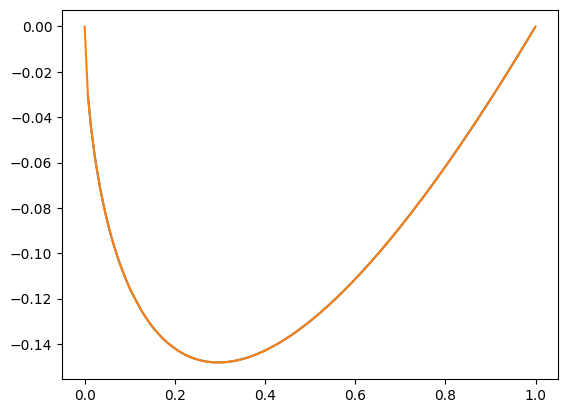

In [61]:
plt.plot(X[1:-1], U)
plt.plot(X, w2(X))

In [13]:
np.max(U)

0.9825540665992101

### Error in $L^2$ and $H^1$

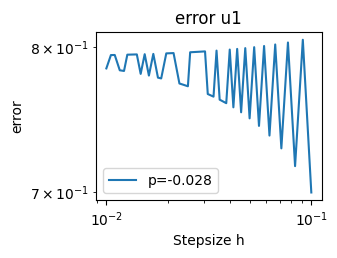

In [51]:
w1_e, w1_H = loglog_error(f_w1, w1)  #, norm='L2')
p = np.polyfit(np.log(w1_H), np.log(w1_e), 1)[0]
plt.subplot(2,2,3, title='error u1')
plt.loglog(w1_H, w1_e, label=f"p={p:.3f}")
plt.xlabel('Stepsize h')
plt.ylabel('error')
plt.legend()


In [23]:
simpsons_rule(*np.linspace(0, 1, 10, retstep=True))

0.46502057613168724

In [50]:
def simpsons_rule_2(f, dx):

    return (dx/3) * (f[0] + 2*np.sum(f[:-2:2]) + 4*np.sum(f[1:-1:2]) + f[-1])


for n in range(3, 20):
    print(f"n={n}: {simpsons_rule_2(*np.linspace(0, 1, n, retstep=True))}")
# print(simpsons_rule(x**2, dx))

n=3: 0.5
n=4: 0.2592592592592592
n=5: 0.5
n=6: 0.3333333333333333
n=7: 0.5
n=8: 0.37414965986394555
n=9: 0.5
n=10: 0.39917695473251025
n=11: 0.5
n=12: 0.4159779614325069
n=13: 0.5
n=14: 0.42800788954635116
n=15: 0.4999999999999999
n=16: 0.437037037037037
n=17: 0.5
n=18: 0.44405997693194926
n=19: 0.5
